### COVID-19 Tracking for Province of Ontario

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
%config InlineBackend.figure_format = 'retina'

# Set large plotting parameters
plt.rcParams["figure.figsize"] = (20.0, 8.0)
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["lines.markersize"] = 15
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams['axes.facecolor'] = 'white'

In [6]:
from datetime import datetime
todaystring = datetime.now().strftime("%Y-%m-%d")

### Data Manipulation
Read in the data

In [7]:
!ls ../midas/

Cases_in_Ontario_2020-02-11.csv Cases_in_Ontario_2020-03-04.csv
Cases_in_Ontario_2020-02-12.csv Cases_in_Ontario_2020-03-05.csv
Cases_in_Ontario_2020-02-13.csv Cases_in_Ontario_2020-03-06.csv
Cases_in_Ontario_2020-02-14.csv Cases_in_Ontario_2020-03-07.csv
Cases_in_Ontario_2020-02-15.csv Cases_in_Ontario_2020-03-08.csv
Cases_in_Ontario_2020-02-16.csv Cases_in_Ontario_2020-03-09.csv
Cases_in_Ontario_2020-02-17.csv Cases_in_Ontario_2020-03-10.csv
Cases_in_Ontario_2020-02-18.csv Cases_in_Ontario_2020-03-11.csv
Cases_in_Ontario_2020-02-19.csv Cases_in_Ontario_2020-03-12.csv
Cases_in_Ontario_2020-02-20.csv Cases_in_Ontario_2020-03-13.csv
Cases_in_Ontario_2020-02-21.csv Cases_in_Ontario_2020-03-14.csv
Cases_in_Ontario_2020-02-22.csv Cases_in_Ontario_2020-03-15.csv
Cases_in_Ontario_2020-02-23.csv Cases_in_Ontario_2020-03-16.csv
Cases_in_Ontario_2020-02-24.csv Cases_in_Ontario_2020-03-17.csv
Cases_in_Ontario_2020-02-25.csv Cases_in_Ontario_2020-03-18.csv
Cases_in_Ontario_2020-02-26.csv Cases_in

In [8]:
import glob

path = r'../midas/' # use your path
all_files = glob.glob(path + "/Cases*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

/Users/mylesharrison/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


In [9]:
frame['DataUpdated'] = pd.to_datetime(frame['DataUpdated'])
frame.sort_values(by='DataUpdated', inplace=True)
frame.tail()

,Confirmed negative,Confirmed positive,Currently under investigation,DataUpdated,Deceased,Footnotes,Negative,Presumptive negative,Presumptive positive,Resolved,Total number of patients approved for 2019-nCoV testing to date,Total number of patients approved for COVID-19 testing to date
42,NaN,369,7239,2020-03-21 10:30:00-04:00,2.0,Negative: Patient negative based on testing pe...,15768.0,NaN,NaN,6.0,NaN,23384.0
39,NaN,368,7239,2020-03-21 17:30:00-04:00,3.0,Negative: Patient negative based on testing pe...,15768.0,NaN,NaN,6.0,NaN,23384.0
38,NaN,412,8361,2020-03-22 17:30:00-04:00,5.0,Negative: Patient negative based on testing pe...,17634.0,NaN,NaN,8.0,NaN,26420.0
37,NaN,489,8417,2020-03-23 17:30:00-04:00,6.0,Negative: Patient negative based on testing pe...,19586.0,NaN,NaN,8.0,NaN,28506.0
34,NaN,572,10074,2020-03-24 17:30:00-04:00,8.0,Negative: Patient negative based on testing pe...,21795.0,NaN,NaN,8.0,NaN,32457.0


In [10]:
merge_columns = lambda s1, s2: s1 if np.isnan(s2) else s2

In [11]:
frame['total_tested'] = frame['Total number of patients approved for 2019-nCoV testing to date'].combine(frame['Total number of patients approved for COVID-19 testing to date'], merge_columns)
frame['presumed_or_confirmed_positive'] = frame['Presumptive positive'].combine(frame['Confirmed positive'], merge_columns)
frame['presumed_or_confirmed_negative'] = frame['Presumptive negative'].combine(frame['Confirmed negative'], merge_columns).combine(frame['Resolved'], merge_columns)

In [12]:
frame['DataUpdated'] = pd.to_datetime(frame['DataUpdated'], utc=True)
frame.sort_values(by='DataUpdated', inplace=True)

In [18]:
# Write csv output
frame.to_csv('../csv/case_statuses_'+todaystring+'.csv')

/Users/mylesharrison/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


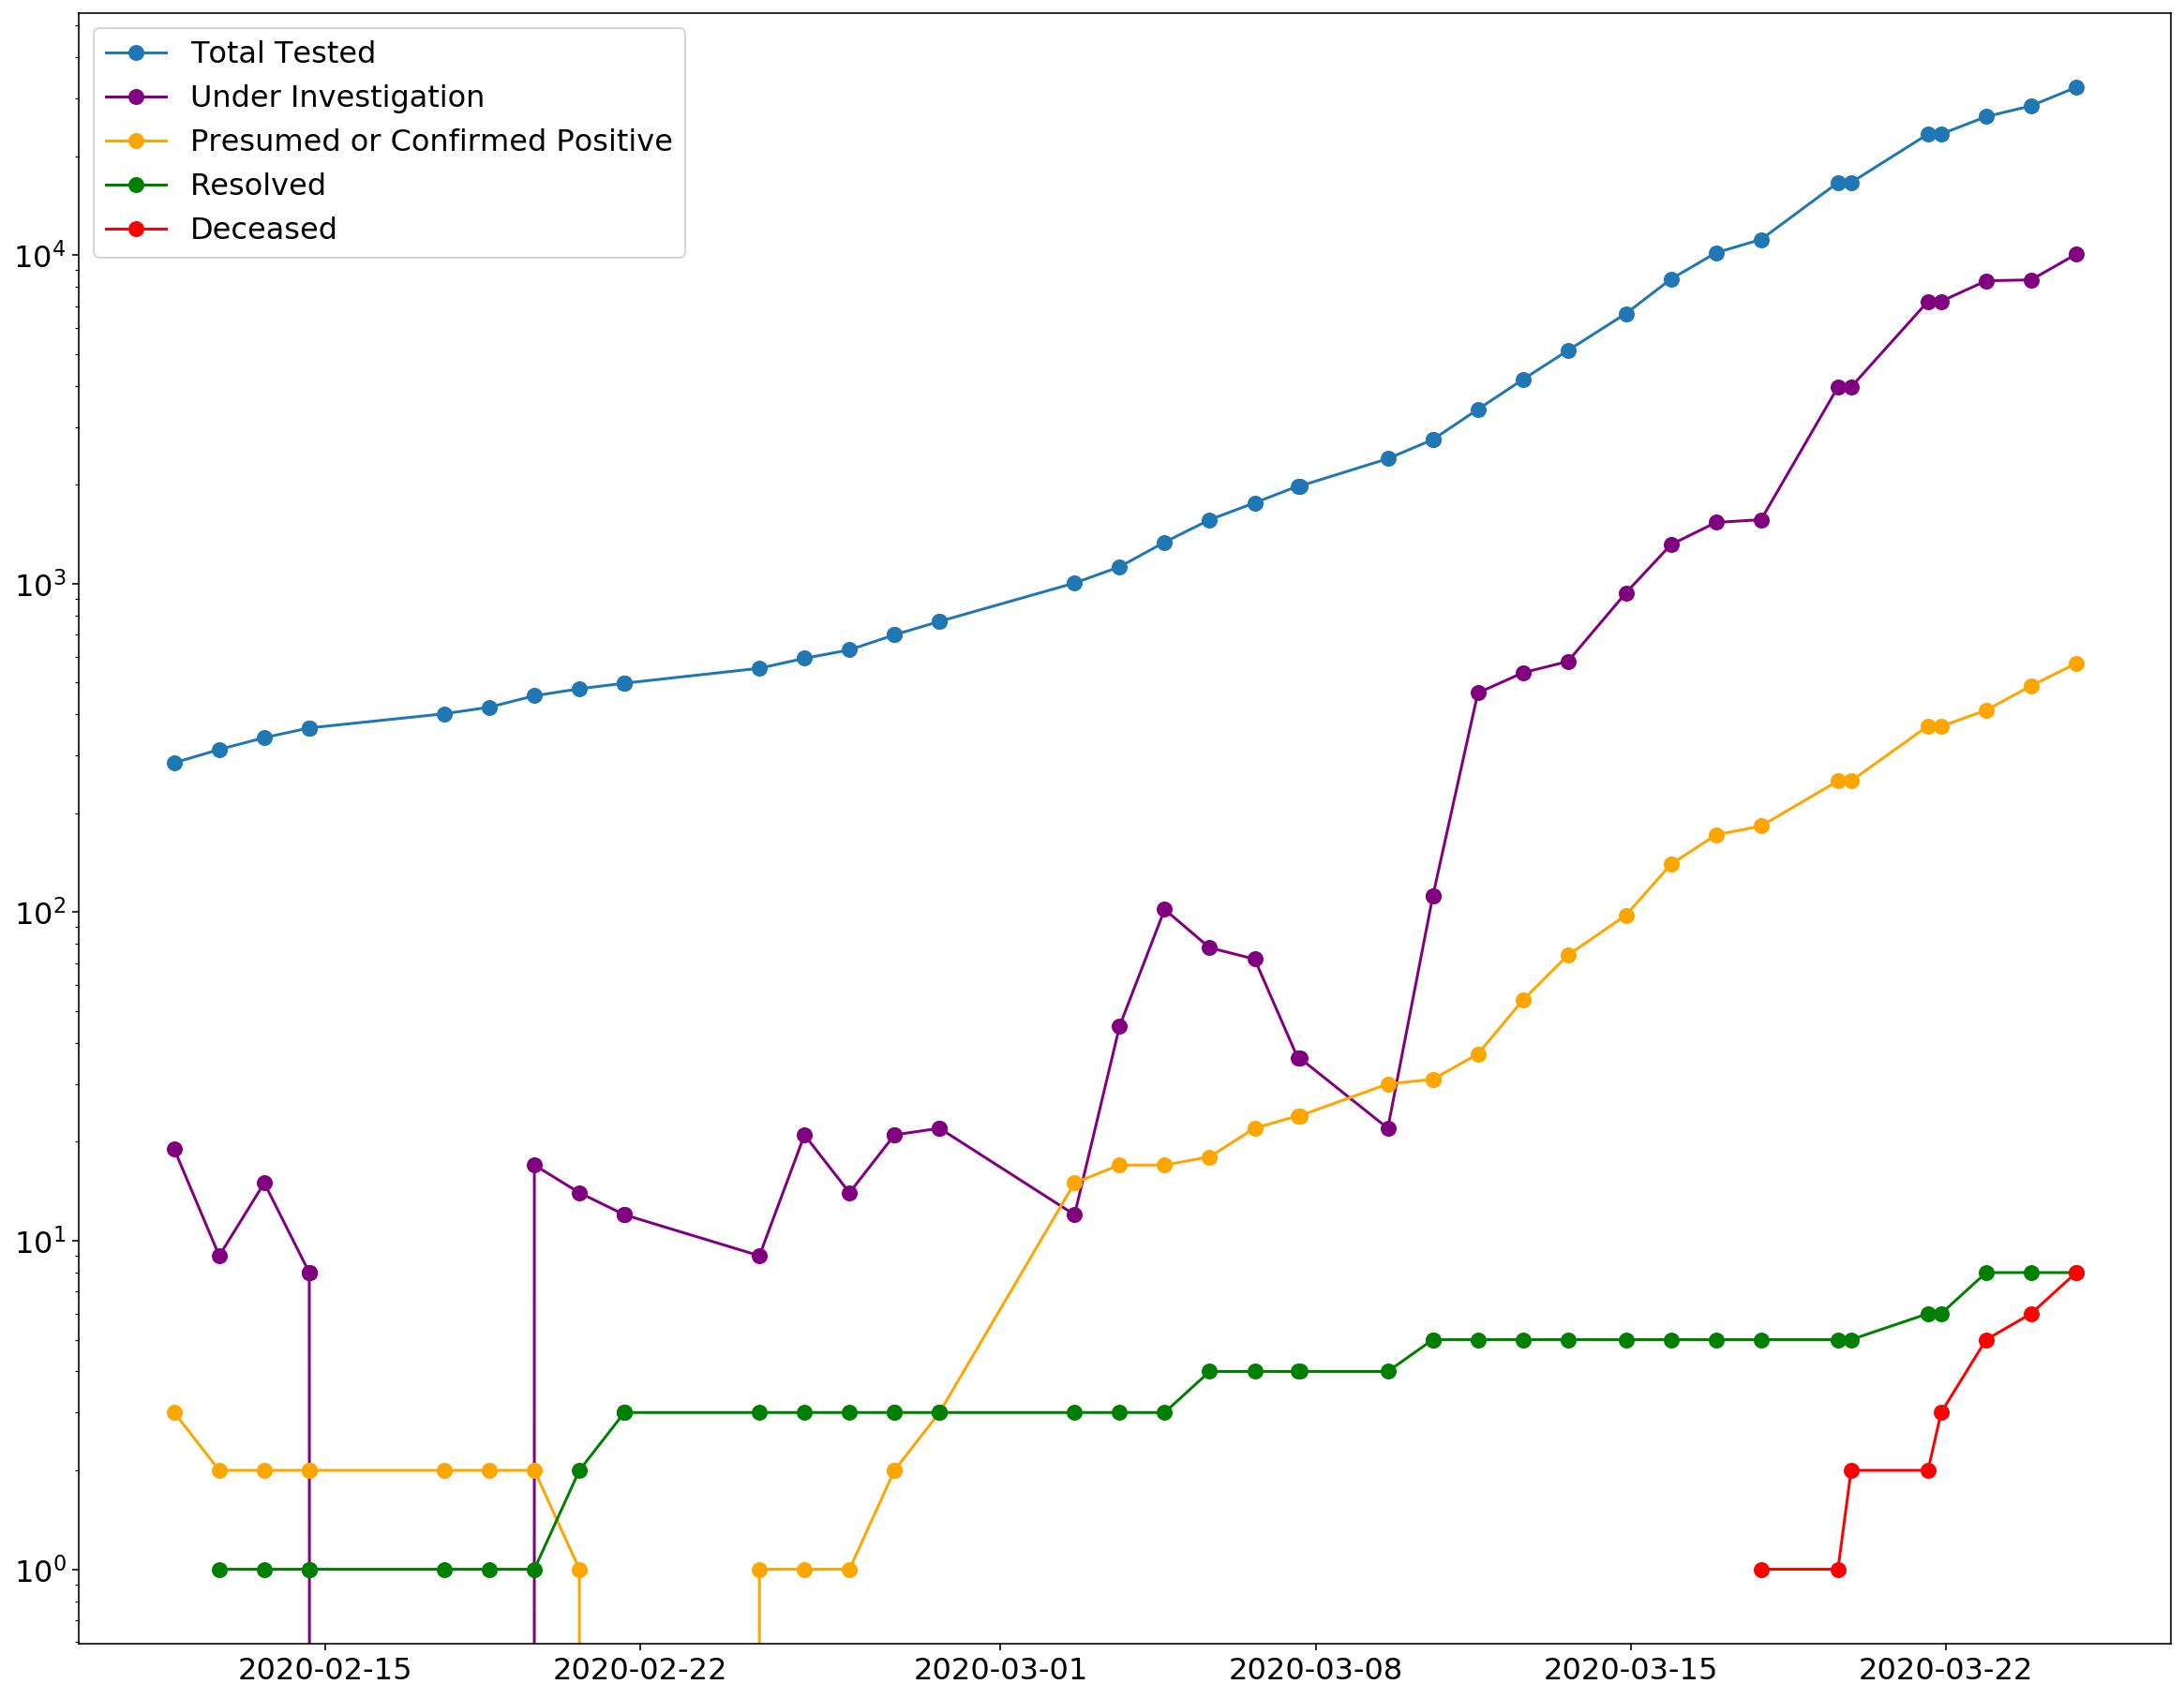

In [13]:
# Combined plot
fig = plt.figure(figsize=(20, 16))
plt.plot(frame['DataUpdated'], frame['total_tested'], label='Total Tested', marker='.')
plt.plot(frame['DataUpdated'], frame['Currently under investigation'], label='Under Investigation', color='purple', marker='.')
plt.plot(frame['DataUpdated'], frame['presumed_or_confirmed_positive'], label='Presumed or Confirmed Positive', color='orange', marker='.')
plt.plot(frame['DataUpdated'], frame['Resolved'], label='Resolved', color='green', marker='.')
plt.plot(frame['DataUpdated'], frame['Deceased'], label='Deceased', color='red', marker='.')
plt.legend()
plt.yscale('log')
plt.show()
fig.savefig('../plots/summaryplot_' + todaystring + '.png')

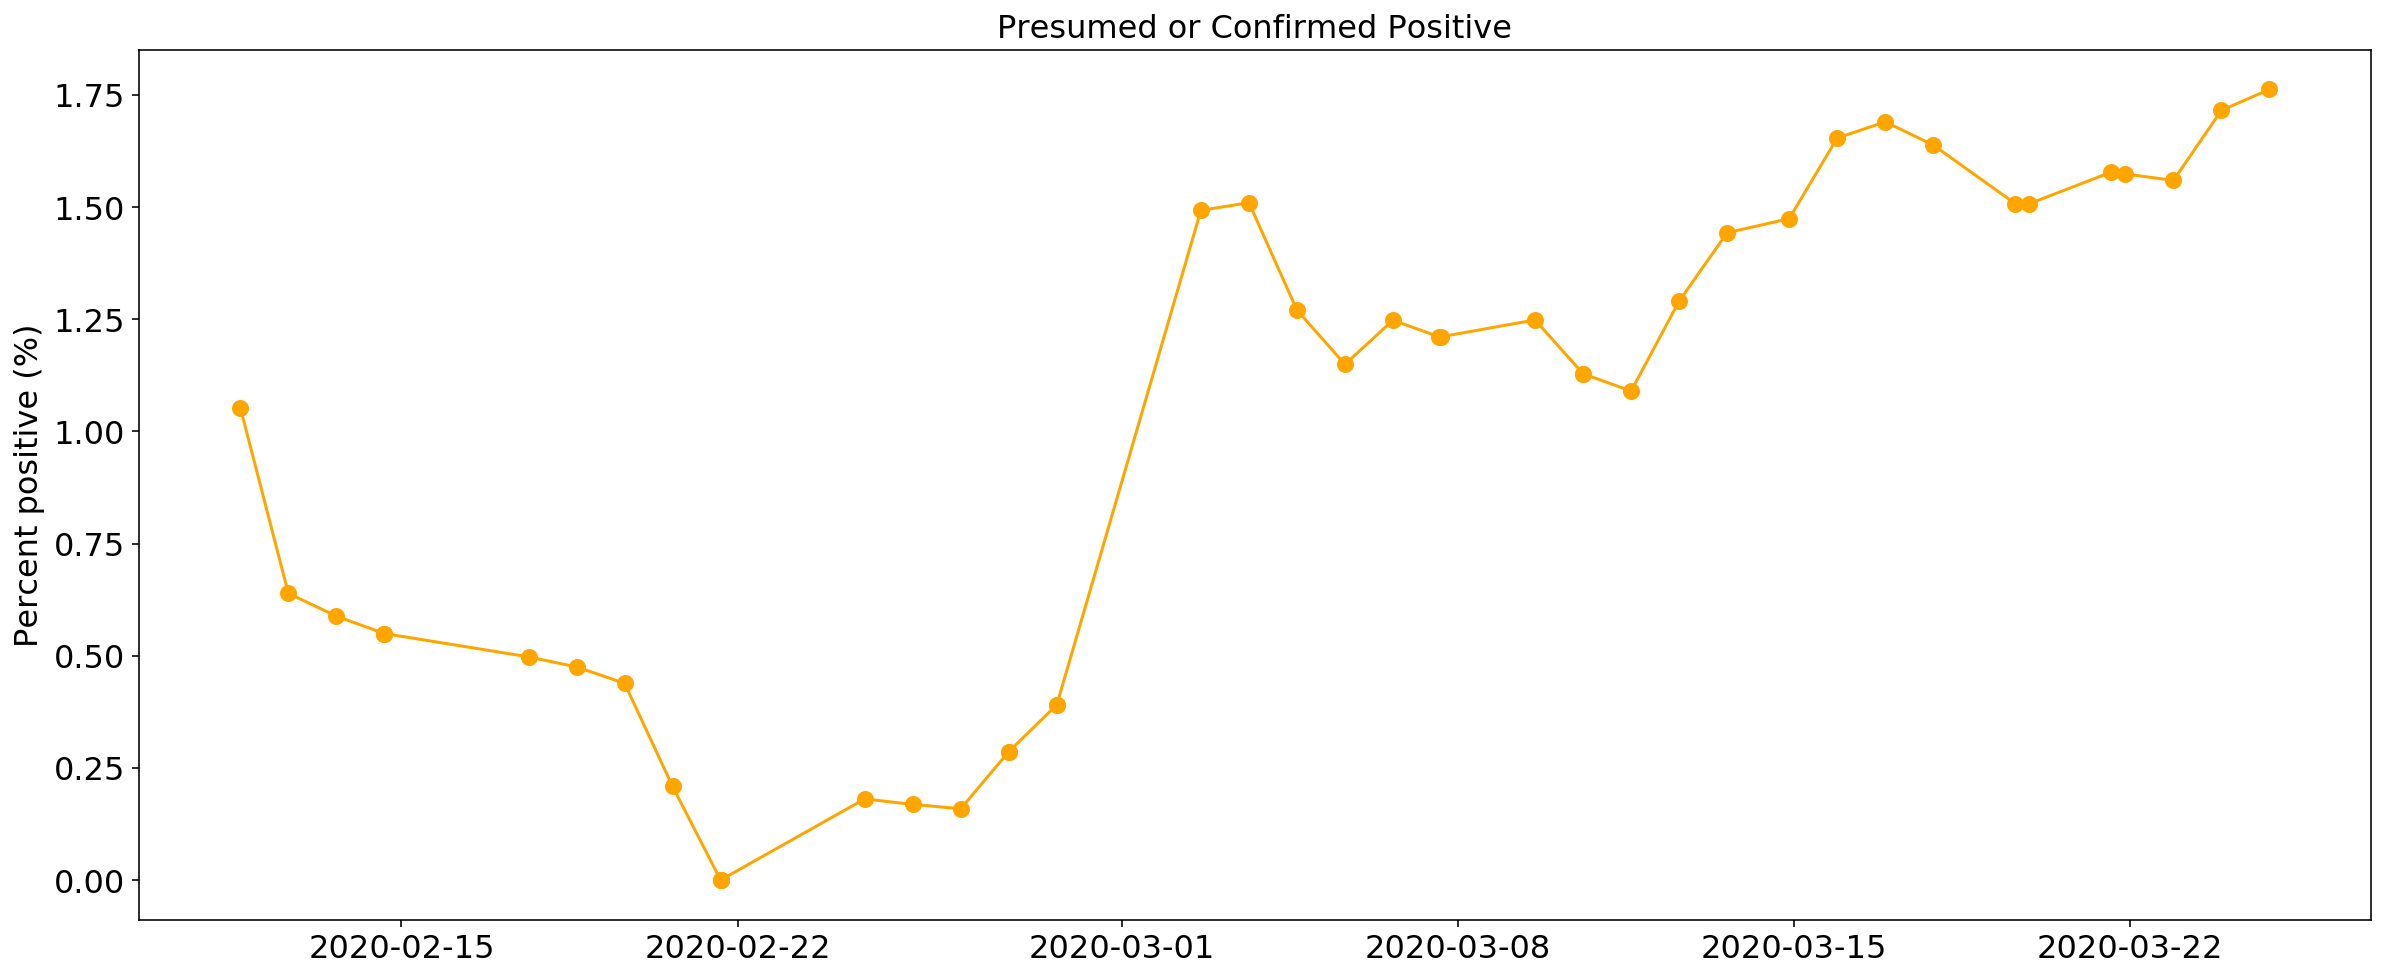

In [23]:
# Positive
positive_fig = plt.figure()
plt.plot(frame['DataUpdated'], frame['presumed_or_confirmed_positive']/frame['total_tested']*100.0, marker='.', color='orange')
plt.ylabel('Percent positive (%)')
plt.title('Presumed or Confirmed Positive')
plt.show()
positive_fig.savefig('../plots/positiveplot_' + todaystring + '.png')

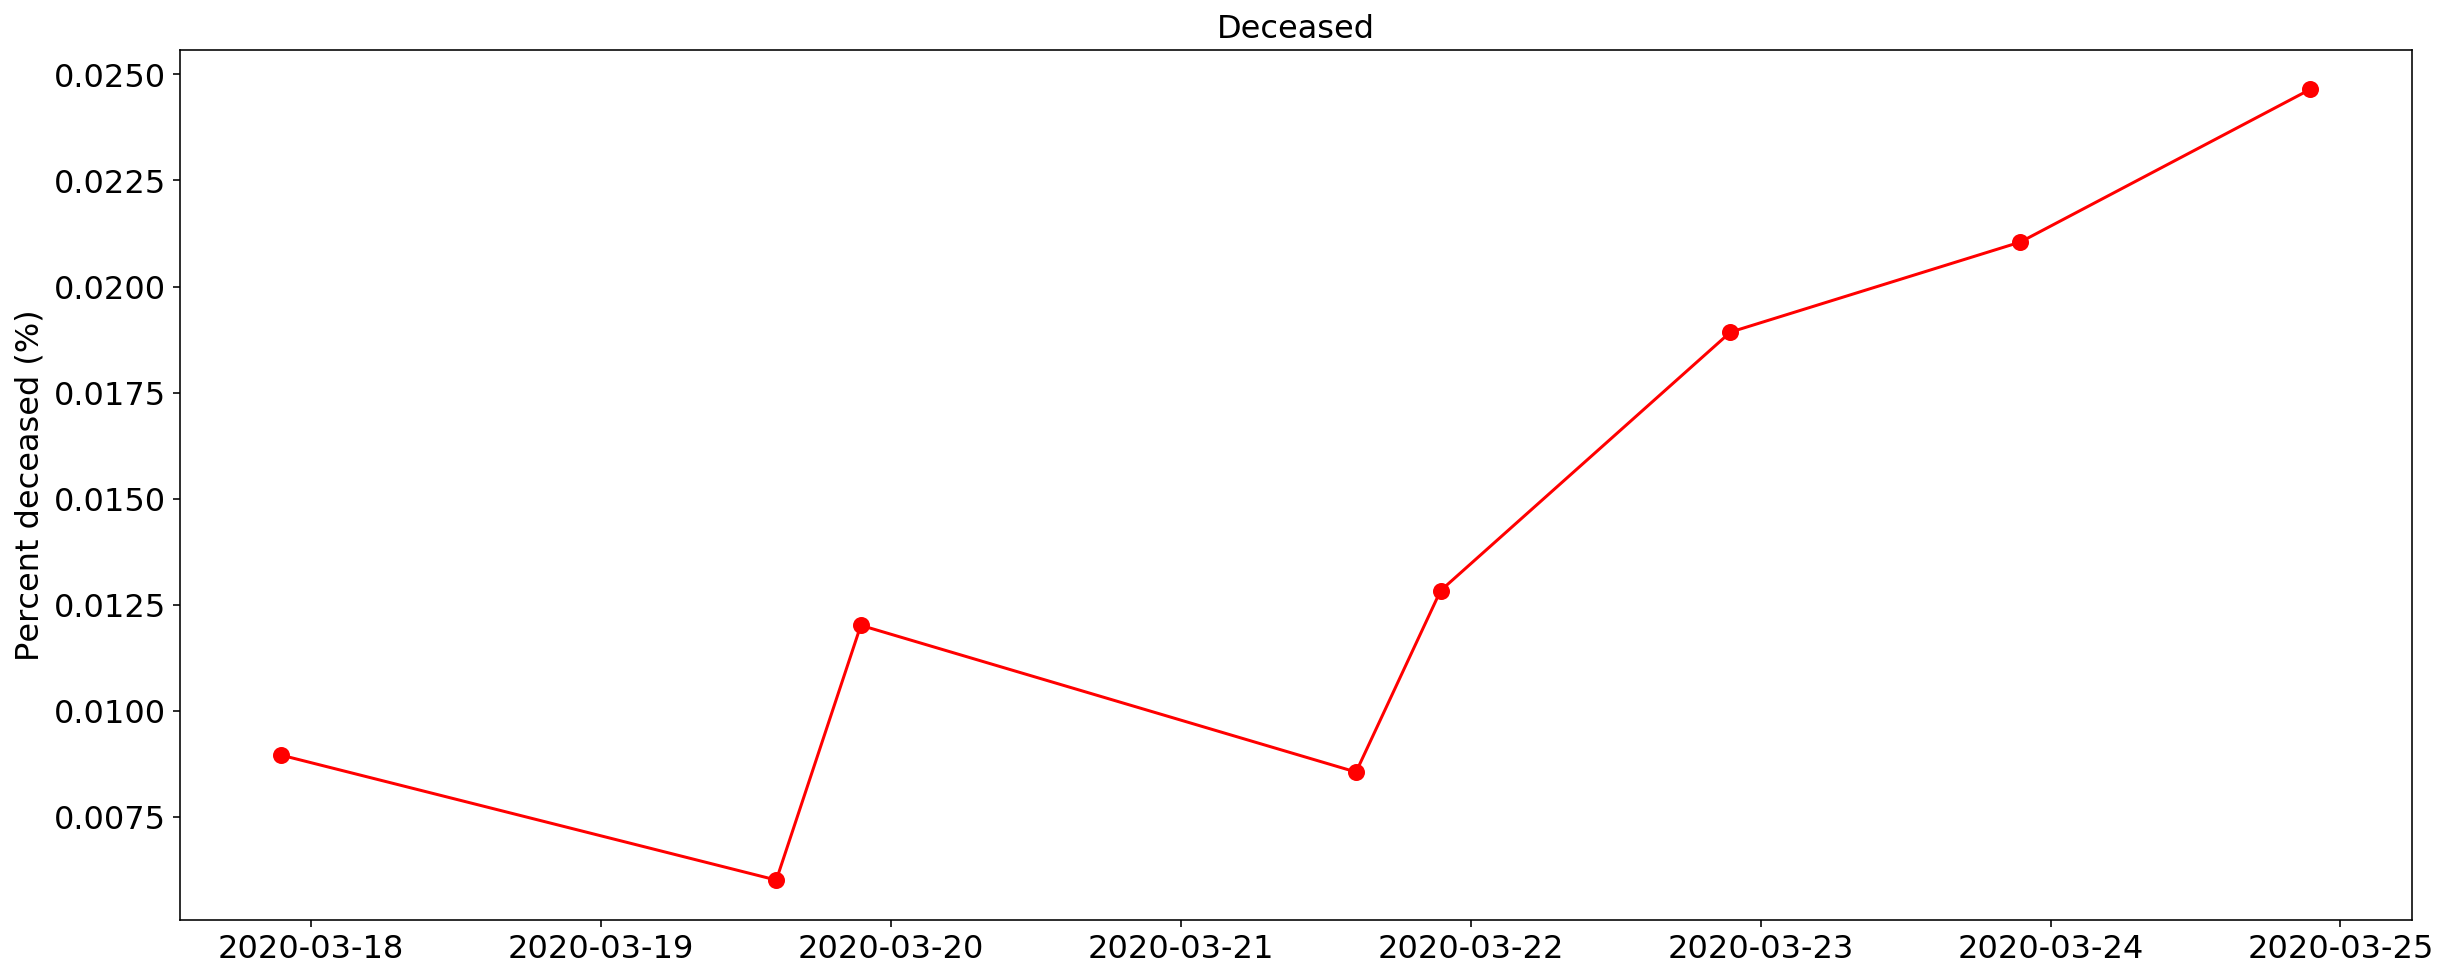

In [24]:
# Deceased
deceased_fig = plt.figure(figsize=(20, 8))
plt.plot(frame['DataUpdated'], frame['Deceased']/frame['total_tested']*100.0, marker='.', color='red')
plt.ylabel('Percent deceased (%)')
plt.title('Deceased')
plt.show()
deceased_fig.savefig('../plots/deceasedplot_' + todaystring + '.png')

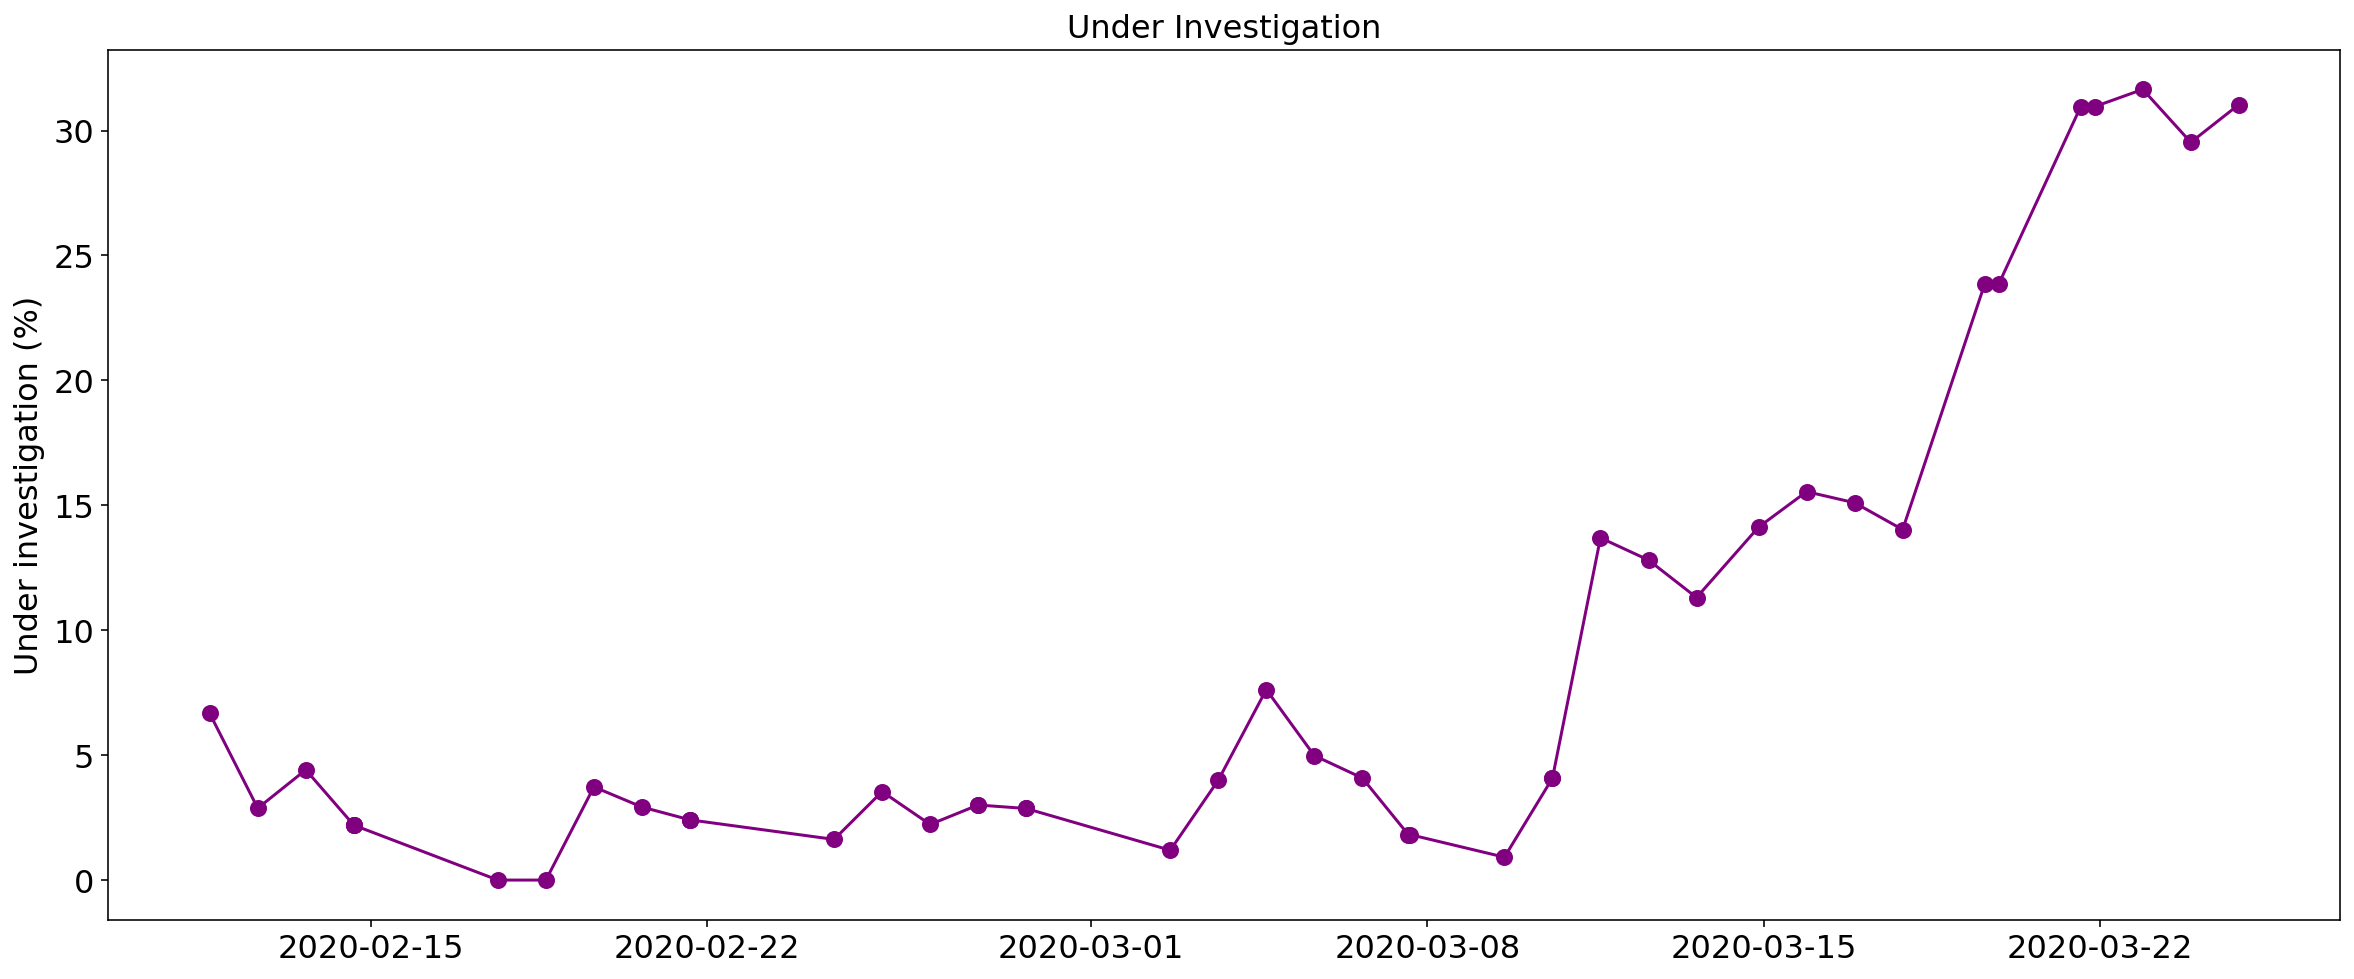

In [25]:
# Under investigation
investigation_fig = plt.figure()
plt.title('Under Investigation')
plt.plot(frame['DataUpdated'], frame['Currently under investigation']/frame['total_tested']*100.0, marker='.', color='purple')
plt.ylabel('Under investigation (%)')
plt.show()
fig.savefig('../plots/investigationplot_' + todaystring + '.png')

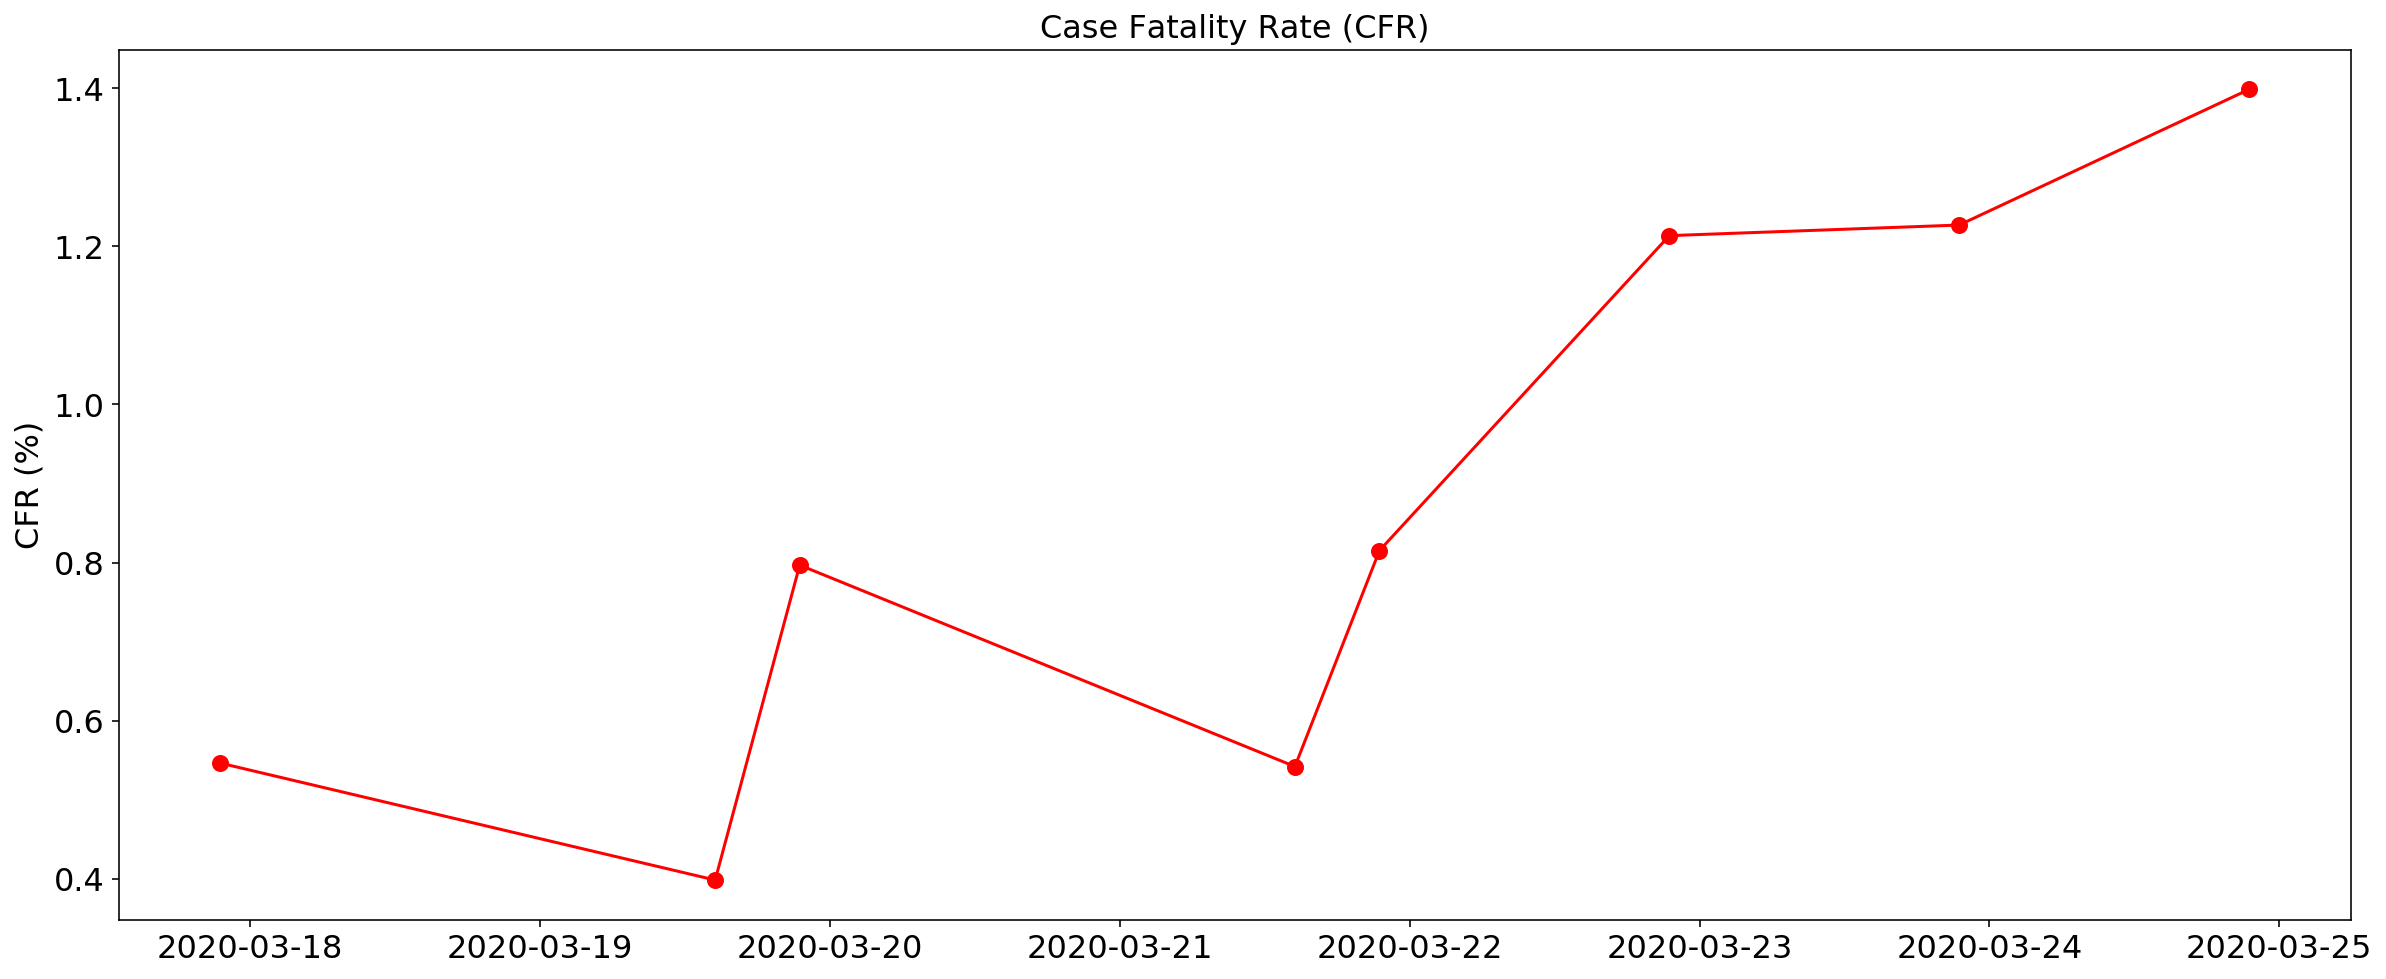

In [26]:
# CFR? 
cfr_fig = plt.figure()
plt.title('Case Fatality Rate (CFR)')
plt.plot(frame['DataUpdated'], frame['Deceased']/frame['presumed_or_confirmed_positive']*100.0, marker='.',color='red')
plt.ylabel('CFR (%)')
plt.show()
fig.savefig('../plots/cfrplot_' + todaystring + '.png')